In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#plt.style.use('bmh')
plt.style.use("seaborn-colorblind")
import sys
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pynoddy/")

import pynoddy.history
import pynoddy.output
import pynoddy.experiment

import pymc

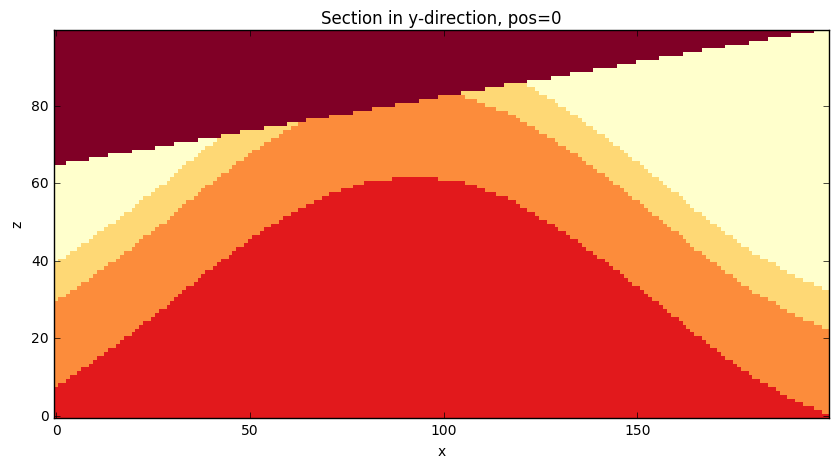

In [111]:
cs = 10

nm = pynoddy.history.NoddyHistory()
nm.set_extent(2000.,20.,1000.)
# set model origin x,y,z
nm.set_origin(0.,0.,1000.)
# set model cube size
nm.change_cube_size(cs)

strati_options = {'num_layers' : 4,
                  'layer_names' : ['4','3','2','1'],
                  'layer_thickness' : [0,300,220,100]} # is this actually the position/height of the layer boundary?!
nm.add_event('stratigraphy', strati_options )

tilt_options = {
    "name": "tilt1",
    "pos": (700,0,1000),
    "rotation": 0.,
    "plunge_direction": 0.,
    "plunge": 0.
}

nm.add_event("tilt", tilt_options)

fold_options = {
    "name": "fold1",
    "pos": (300,0,0),
    "amplitude": 325.,
    "wavelength": 2500.,
    "dip": 90.,
    "dip_dir": 90.
}

nm.add_event("fold", fold_options)

unconf_options = {
    "name": "unfonf1",
    "pos": (0,0,650),
    "rotation": 0.,
    "dip_direction": 90.,
    "dip": -10.,
    "num_layers": 1,
    "layer_names": ["a"],
    "layer_thickness": [700]
}

nm.add_event("unconformity", unconf_options)

nm.write_history("nm_exp2.his")
ex = pynoddy.experiment.Experiment("nm_exp2.his")
ex.plot_section("y")

In [23]:
def modify_and_plot(rotation, amplitude, wavelength, unconf_Z, unconf_dip):
    ex.events[2].properties["Rotation"] = rotation
    ex.events[3].properties["Amplitude"] = amplitude
    ex.events[3].properties["Wavelength"] = wavelength
    
    ex.events[4].properties["Z"] = unconf_Z
    ex.events[4].properties["Dip"] = unconf_dip
    
    ex.plot_section("y")

In [24]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

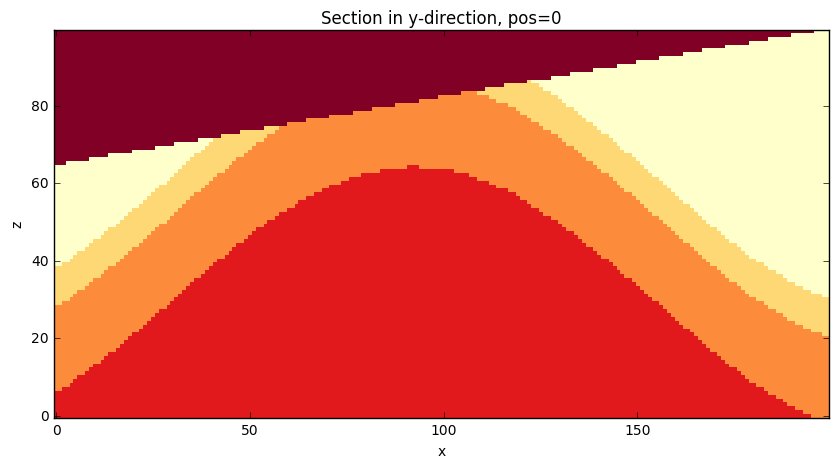

In [25]:
interact(modify_and_plot, rotation=(-90,90), amplitude=(0,500,25), wavelength=(500,2500,100), unconf_Z=(600,1000,25), unconf_dip=(-30,10,2));

In [26]:
prior_dict = {
    "stratigraphy_rotation": {
        "mean": 0.,
        "stdev": 5.
    },
    "layer1_height": {
        "mean": 300.,
        "stdev": 30.
    },
    "layer2_height": {
        "mean": 500.,
        "stdev": 50.
    },
    "unconformity_height": {
        "mean": 650.,
        "stdev": 65.
    },
    "unconformity_rotation": {
        "mean": -10.,
        "stdev": 5.
    },
    "fold_amplitude": {
        "mean": 350.,
        "stdev": 25.
    },
    "fold_wavelength": {
        "mean": 2500.,
        "stdev": 140.
    }
    
}

## Mean Prior Model

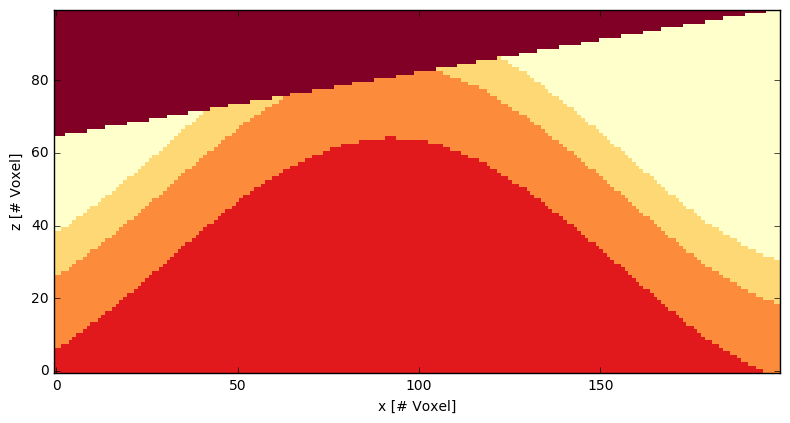

In [28]:
# layer height
ex.events[1].layers[1].properties["Height"] = prior_dict["layer1_height"]["mean"]
ex.events[1].layers[2].properties["Height"] = prior_dict["layer2_height"]["mean"]

# stratigraphy rotation
ex.events[2].properties['Rotation'] = prior_dict["stratigraphy_rotation"]["mean"]

# fold
ex.events[3].properties["Amplitude"] = prior_dict["fold_amplitude"]["mean"]
ex.events[3].properties["Wavelength"] = prior_dict["fold_wavelength"]["mean"]

# unconformity
ex.events[4].properties["Z"] = prior_dict["unconformity_height"]["mean"]
ex.events[4].properties["Dip"] = prior_dict["unconformity_rotation"]["mean"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

ex.plot_section("y", ax=ax)
ax.set_xlabel("x [# Voxel]")
ax.set_ylabel("z [# Voxel]")
ax.legend(loc="upper left")
ax.set_title("")
plt.tight_layout()



#ax.axvline(500/cs, color="black", label="Drill Hole")

In [29]:
prior_dict.keys()

['unconformity_rotation',
 'layer2_height',
 'fold_amplitude',
 'stratigraphy_rotation',
 'unconformity_height',
 'layer1_height',
 'fold_wavelength']

In [32]:
# prior objects
layer1_height = pymc.Normal("layer1_height", prior_dict["layer1_height"]["mean"], 1./np.square(prior_dict["layer1_height"]["stdev"]))
layer2_height = pymc.Normal("layer2_height", prior_dict["layer2_height"]["mean"], 1./np.square(prior_dict["layer2_height"]["stdev"]))
stratigraphy_rotation = pymc.Normal("stratigraphy_rotation", prior_dict["stratigraphy_rotation"]["mean"], 1./np.square(prior_dict["stratigraphy_rotation"]["stdev"]))
fold_amplitude = pymc.Normal("fold_amplitude", prior_dict["fold_amplitude"]["mean"], 1./np.square(prior_dict["fold_amplitude"]["stdev"]))
fold_wavelength = pymc.Normal("fold_wavelength", prior_dict["fold_wavelength"]["mean"], 1./np.square(prior_dict["fold_wavelength"]["stdev"]))
unconformity_height = pymc.Normal("unconformity_height", prior_dict["unconformity_height"]["mean"], 1./np.square(prior_dict["unconformity_height"]["stdev"]))
unconformity_rotation = pymc.Normal("unconformity_rotation", prior_dict["unconformity_rotation"]["mean"], 1./np.square(prior_dict["unconformity_rotation"]["stdev"]))

In [157]:
history = "nm_exp2.his"
# create initial pynoddy experiment object
ex_mcmc = pynoddy.experiment.Experiment(history)

# define deterministic function for the model creation:
@pymc.deterministic
def pynoddy_model(value=0, 
                 stratigraphy_rotation=stratigraphy_rotation, 
                 fold_amplitude=fold_amplitude, 
                 fold_wavelength=fold_wavelength, 
                 layer1_height=layer1_height, 
                 layer2_height=layer2_height, 
                 unconformity_height=unconformity_height,
                 unconformity_rotation=unconformity_rotation,
                 ex=ex_mcmc, cs=cs):
    """
    Whoop-dee Whoop.
    """
    # modify event 1: stratigraphy
    ex.events[1].layers[1].properties["Height"] = layer1_height
    ex.events[1].layers[2].properties["Height"] = layer2_height
    
    # modify event 2: rotation of stratigraphy
    ex.events[2].properties['Rotation'] = stratigraphy_rotation
    
    # modify event 3: fold
    ex.events[3].properties["Amplitude"] = fold_amplitude
    ex.events[3].properties["Wavelength"] = fold_wavelength

    # modify event 4: unconformity
    ex.events[4].properties["Z"] = unconformity_height
    ex.events[4].properties["Dip"] = unconformity_rotation
    
    # write history of modified experiment
    ex.write_history("pymc_history.his")
    # compute model with files necessary for topology analysis
    pynoddy.compute_model("pymc_history.his", "pymc_noddy_output", sim_type="TOPOLOGY")
    model = pynoddy.output.NoddyOutput("pymc_noddy_output")
    # return model section
    return model.block[:,0,:]

@pymc.deterministic
def pynoddy_topology(value=0, pynoddy_model=pynoddy_model):
    # compute topology
    pynoddy.compute_topology("pymc_noddy_output", topology_path=topology_path, type="TOPOLOGY");
    
    # load computed topology output
    topology = pynoddy.output.NoddyTopology("pymc_noddy_output")

    #return topology object
    return topology

#as we want some good-ass Monte Carlo Forward Modelling, we ain't need no likelihood!
#@pymc.stochastic
#def like_layer2_height(value=0, well=pynoddy_well):
#    if len(np.where(well==3)[0]) < 1:
#        layer2_height = -9999
#    else:
#        layer2_height = np.where(well==3)[0][0]
#    return pymc.normal_like(layer2_height, 375., 1./np.square(15.))

model = pymc.Model([stratigraphy_rotation, unconformity_height, unconformity_rotation, layer1_height, layer2_height, fold_amplitude, fold_wavelength, pynoddy_model, pynoddy_topology])

In [158]:
RUN = pymc.MCMC(model)
RUN.sample(iter=20)

 [-----------------105%------------------] 21 of 20 complete in 18.8 sec

In [159]:
pynoddy_model_posterior = RUN.trace("pynoddy_model")[:]
def plot_posterior_section(x):
    plt.imshow(pynoddy_model_posterior[x].T, origin="lower left", interpolation="nearest")

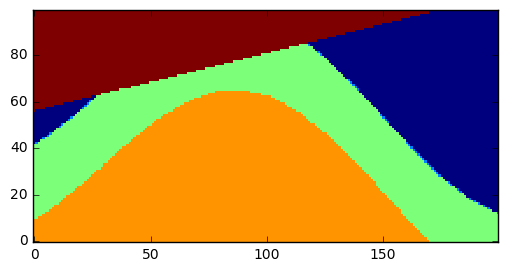

In [160]:
interact(plot_posterior_section, x=(0,20));

## Topology

In [68]:
topology_path = "topology.exe"

In [117]:
pynoddy.compute_model(history, "pynoddy_out", sim_type="TOPOLOGY")
pynoddy.compute_topology("pynoddy_out", topology_path=topology_path, type="TOPOLOGY");

In [113]:
topology = pynoddy.output.NoddyTopology("pynoddy_out")
out = pynoddy.output.NoddyOutput("pynoddy_out")

In [114]:
def visualize_nodes(topology, model):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

    model.plot_section("y", ax=ax)

    # plot nodes
    cs = 10.
    for key in topology.graph.node.keys():
        #print node[1]["centroid"]
        ax.plot(topology.graph.node[key]["centroid"][0]/cs,topology.graph.node[key]["centroid"][2]/cs, "ko")
        ax.text(topology.graph.node[key]["centroid"][0]/cs,topology.graph.node[key]["centroid"][2]/cs, str(key), color="black")
        for edge in topology.graph.edge[key]:
            plt.plot([topology.graph.node[key]["centroid"][0]/cs,topology.graph.node[edge]["centroid"][0]/cs],
                     [topology.graph.node[key]["centroid"][2]/cs,topology.graph.node[edge]["centroid"][2]/cs],
                      topology.graph.edge[key][edge]["colour"])

    # plot details
    ax.set_xlim(0)
    ax.set_ylim(0);

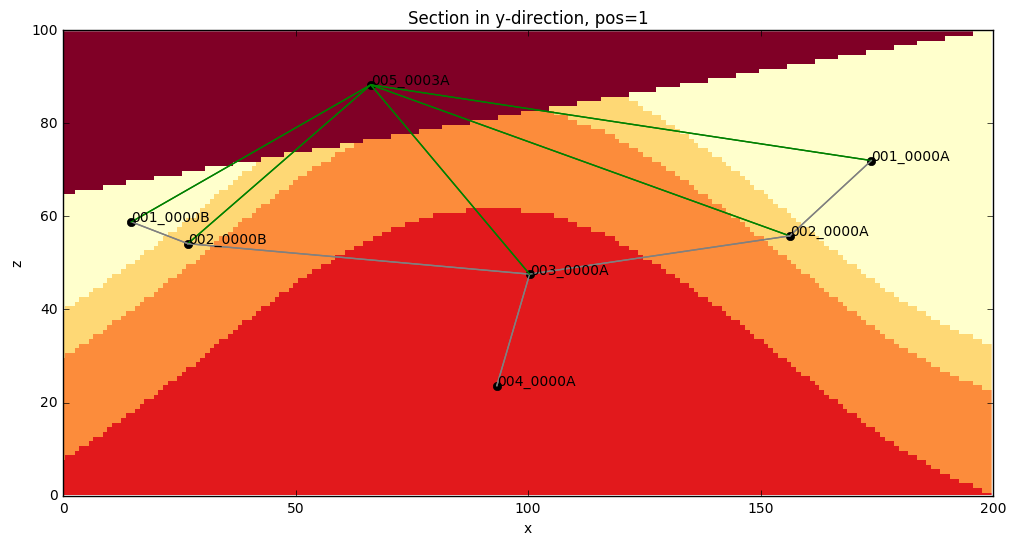

In [118]:
visualize_nodes(topology,out)

In [150]:
def check_adjacency(layerA,layerB,topology):
    """
    Check for adjacency of the two layers A and B. Returns True if connected, else False. Function should hold true even for 
    very weird model realisations with unexpected edges.
    layerA,layerB: str like "003" for layer #3
    """
    adjacency = None
    for node in topology.graph.node.keys():
        if layerA in node:
            #print topology.graph.edge[node].keys()
            for edge in topology.graph.edge[node].keys():
                if layerB in edge:
                    #print topology.graph.edge[node][edge]
                    #print "Node ",layerA," and ",layerB," share an edge!"
                    adjacency = True
    if adjacency is True:
        return True
    else:
        return False

## Parameter Extraction

extract values for geomodeller:

* extract layer thickness at several positions to remodel fold

In [182]:
%matplotlib inline

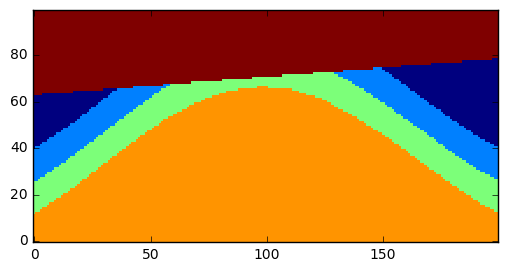

In [183]:
plt.imshow(pynoddy_model_posterior[12].T, origin="lower left", interpolation="nearest")

### layer identification
* orange = 4
* green = 3
* light_blue = 2
* dark_blue = 1
* red = 5

In [38]:
import pandas as pd

In [40]:
foliation_col_names = ["X", "Y", "Z", "azimuth", "dip", "polarity", "formation"]
interfaces_col_names = ["X", "Y", "Z", "formation"]

interfaces = pd.DataFrame(columns=interfaces_col_names)
foliations = pd.DataFrame(columns=foliation_col_names)

In [173]:
model = pynoddy_model_posterior[12]
model

array([[ 4.,  4.,  4., ...,  5.,  5.,  5.],
       [ 4.,  4.,  4., ...,  5.,  5.,  5.],
       [ 4.,  4.,  4., ...,  5.,  5.,  5.],
       ..., 
       [ 4.,  4.,  4., ...,  5.,  5.,  5.],
       [ 4.,  4.,  4., ...,  5.,  5.,  5.],
       [ 4.,  4.,  4., ...,  5.,  5.,  5.]])

In [176]:
np.shape(model[:,0])

(200L,)

In [177]:
np.shape(model[0,:])

(100L,)

In [178]:
model[0,:]

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.])

In [187]:
np.arange(0,200,20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

In [200]:
np.unique(model[160,:])

array([ 1.,  2.,  3.,  4.,  5.])

In [216]:
def extract_interfaces(model, step_size=20):
    x_pos = np.arange(0,len(model[:,0]),step_size)
    
    interfaces_col_names = ["X", "Y", "Z", "formation"]
    interfaces = pd.DataFrame(columns=interfaces_col_names)
    
    loc = 0 # index variable for pandas
    for x in x_pos:
        for layer in np.unique(model[x,:]):
            loc += 1
            if len(np.where(model[x,:]==layer)[0]) is 0:
                pass
            else:
                z = np.where(model[x,:]==layer)[0][0]
                y = 0
                if z == 0. or z == 0:
                    pass
                else:
                    interfaces.loc[loc] = [x,y,z,"Layer"+str(int(layer))]
    
    
    return interfaces

In [229]:
def extract_foliations(model,step_size=20):
    # define x coordinates of extraction "wells"
    x_pos = np.arange(step_size,len(model[:,0]),step_size)
    
    # create pandas dataframe
    foliation_col_names = ["X", "Y", "Z", "azimuth", "dip", "polarity", "formation"]
    foliations = pd.DataFrame(columns=foliation_col_names)
    
    loc = 0 # index variable for pandas
    
    for x in x_pos:
        for layer in np.unique(model[x,:]):
            loc += 1
            
            z1 = np.where(model[x - step_size/2 + 1,:]==layer)[0][0]
            z2 = np.where(model[x + step_size/2 - 1,:]==layer)[0][0]
            
            dz = z1 - z2
            dx = step_size - 2
            tan = float(dz) / float(dx)
            dip = np.rad2deg(np.arctan(tan))
            az = 90.
            pol = 1.
            y = 0.
            foliations.loc[loc] = [x,y,(z1+z2)/2,az,dip,pol,"Layer"+str(int(layer))]
            
    return foliations

In [47]:
interfaces = extract_interfaces(10,12)
foliations = extract_foliations(20,12)

In [52]:
interfaces[interfaces["Z"]!=0].to_csv("interfaces.csv")
foliations[foliations["Z"]!=0].to_csv("foliations.csv")

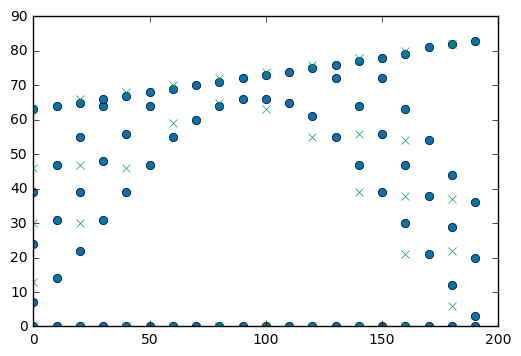

In [48]:
plt.plot(interfaces["X"].values, interfaces["Z"].values,"o")
plt.plot(foliations["X"].values, foliations["Z"].values,"x")

In [357]:
foliations

,X,Y,Z,azimuth,dip,polarity,formation
3,0.0,0.0,33.0,90.0,-43.363423,1.0,Layer3
4,0.0,0.0,0.0,90.0,0.000000,1.0,Layer4
5,0.0,0.0,61.0,90.0,-15.524111,1.0,Layer5
8,20.0,0.0,45.0,90.0,-15.524111,1.0,Layer3
9,20.0,0.0,0.0,90.0,0.000000,1.0,Layer4
10,20.0,0.0,66.0,90.0,-15.524111,1.0,Layer5
13,40.0,0.0,42.0,90.0,31.429566,1.0,Layer3
14,40.0,0.0,0.0,90.0,0.000000,1.0,Layer4
15,40.0,0.0,72.0,90.0,-15.524111,1.0,Layer5
16,60.0,0.0,63.0,90.0,43.363423,1.0,Layer1


In [343]:
interfaces

,X,Y,Z,formation
2,0.0,50.0,0.0,Layer2
3,0.0,25.0,0.0,Layer3
5,0.0,59.0,0.0,Layer5
8,10.0,35.0,0.0,Layer3
10,10.0,61.0,0.0,Layer5
13,20.0,43.0,0.0,Layer3
15,20.0,64.0,0.0,Layer5
18,30.0,47.0,0.0,Layer3
20,30.0,67.0,0.0,Layer5
23,40.0,48.0,0.0,Layer3


In [326]:
import random

In [327]:
random.randint?